import the seminar RL code (assumes you are running in the notebook directory):

In [1]:
import sys
sys.path.append('../deeprl')

# Using OpenAI Gym

In this course we will be using <a href='http://gym.openai.com'>the openAI Gym</a> to run reinforcement learning experiments. The gym collects a number of standardized reinforcement learning environments. It allows monitoring and becnhmarking of RL algorithms on these environments, so that algorithms can be easily compared. A description of the different environments can be found <a href='https://gym.openai.com/envs'>here</a>. In this notebook we will be working with the mountaincar (or car on the hill) environment. The goal in this task is to drive an underpowered car up a steep hill. Because the car does not have the power to drive straight up the hill, it has to first build momentum by going back and forth.

In [2]:
import gym
env = gym.make('MountainCar-v0')

[2016-11-28 18:00:41,591] Making new env: MountainCar-v0


A gym environment contains all relevant data describing the problem. We can directly inspect the action space and the observation space of the environment. In case of mountaincar, we have a discrete action space with 3 actions and a continuous observation space with 2 variables: position $\in$ [-1.2,0.6] and velocity $\in$ [-0.07 and 0.07] 

In [3]:
print env.action_space
print env.observation_space
print env.observation_space.low
print env.observation_space.high
print env.goal_position

Discrete(3)
Box(2,)
[-1.2  -0.07]
[ 0.6   0.07]
0.5


Using an environment is easy. Just repeatedly call the *step* function to perform an action from the action space and observe the results. The step function returns the next observation, the reward and a termination indicator (there is also a dict with additional info, but this is mostly unused).

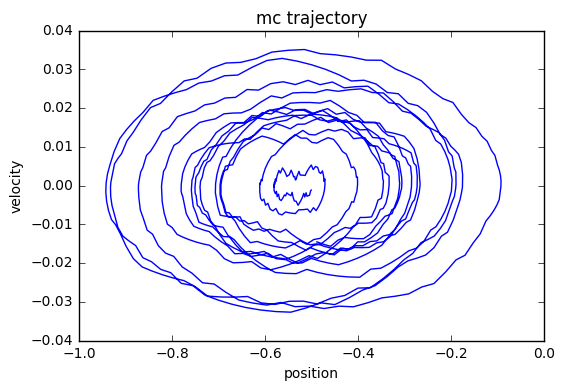

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# initialize the environment
obs = env.reset()
log = []

# perform 1000 steps
for step in range(1000):
    # sample a random action
    action = env.action_space.sample()
    # step the environment and observe the results
    obs,rew,terminal,_ = env.step(action)
    # store state
    log.append(obs)
    
log = np.array(log)

#plot the trajectory
plt.title('mc trajectory')
plt.xlabel('position')
plt.ylabel('velocity')

plt.plot(log[:,0],log[:,1])


# Running DQN

To apply DQN, we first need to create a neural network to represent the Q-function. This neural network will take a state as input and return the Q-values (= expected sum of future rewards) for all actions in that state. Since mountaincar is Markovian we can give a single state observation as input and don't need to provide a sequence of observation as was the case in the DQN paper.

Below we define a function that creates a simple neural network to represent the Q-function. Since we do not have image state observations (as in the atari domain), we do not use a convolutional network. We create a simple multi-layer perceptron with 2 hidden layers. Using <a href='http://tflearn.org/'>the tflearn library</a> we can create a fully connected layer using following function:

<i>fully_connected(inputs,n_nodes,activation,weight_decay)</i>

where <i>inputs</i> are the outputs of the previous layer, <i>n_nodes</i> is the number of hidden units to use, <i>activation</i> is the activation function (e.g. 'relu','linear','sigmoid' or 'tanh') and <i>weight_decay</i> is a regularization parameter to avoid overfitting (higher values force the network to learn simpler functions). We also add dropout layers. These layers help prevent overfitting. They do this by stochastically zeroing the ouput of a percentage network units (this percentage is the dropout rate $\in$ [0,1]).

In [21]:
import tensorflow as tf
import tflearn as nn

def create_mlp(inputs, n_out):
    # input definition, don't change this line
    net = nn.input_data(placeholder=inputs)
    
    # define the hidden layers:
    
    # this creates a standard feedforward network layer with 25 hidden units
    net = nn.fully_connected(net, 25, activation='relu', weight_decay=0.0001)
    # dropout layers help prevent overfitting (0.3 dropout rate)
    net = nn.dropout(net, 0.3)
    net = nn.fully_connected(net, 25, activation='relu', weight_decay=0.0001)
    net = nn.dropout(net, 0.3)

    # output Q-values, don't change
    net = nn.fully_connected(net, n_out, activation='linear')
    return net

Create a DQNAgent and run an experiment on the Mountaincar environment. The DQNAgent class implements a basic DQN. The Experiment class runs an agent on a given envrionment. The <i>run_epoch</i> method runs for a fixed number of steps and returns the cumulatie reward for each finished episode. The parameters below should give reasonable results.

In [29]:
from agents import DQNAgent
from experiment import Experiment

#erase previously created tf graphs
tf.reset_default_graph()

#create a DQNAgent
agent = DQNAgent(create_mlp,  # network creation function
                 env.action_space.n,# number of actions
                 env.observation_space.shape, # state dimensions
                 alpha=0.001, # learning rate 
                 gamma=0.99,# discount factor
                 min_replay_size=1000, # samples to gather before starting training
                 replay_size=100000, # max samples to keep
                 target_freq=10000, # update the target network every #target_freq steps
                 batch_size=64) # number of samples to use for single update


exp = Experiment(agent, env)
# run agent on envrionment for 75K steps
rewards = exp.run_epoch(75000)

[2016-11-28 20:50:31,269] tf.variable_op_scope(values, name, default_name) is deprecated, use tf.variable_scope(name, default_name, values)
[2016-11-28 20:50:31,354] tf.variable_op_scope(values, name, default_name) is deprecated, use tf.variable_scope(name, default_name, values)
[2016-11-28 20:50:31,420] tf.variable_op_scope(values, name, default_name) is deprecated, use tf.variable_scope(name, default_name, values)
[2016-11-28 20:50:31,451] tf.variable_op_scope(values, name, default_name) is deprecated, use tf.variable_scope(name, default_name, values)
[2016-11-28 20:50:31,539] tf.variable_op_scope(values, name, default_name) is deprecated, use tf.variable_scope(name, default_name, values)
[2016-11-28 20:50:31,612] tf.variable_op_scope(values, name, default_name) is deprecated, use tf.variable_scope(name, default_name, values)


episode reward: -4909.000000
episode reward: -1506.000000
episode reward: -738.000000
episode reward: -885.000000
episode reward: -1025.000000
episode reward: -306.000000
episode reward: -290.000000
episode reward: -751.000000
episode reward: -320.000000
episode reward: -753.000000
episode reward: -459.000000
episode reward: -1135.000000
episode reward: -691.000000
episode reward: -538.000000
episode reward: -244.000000
episode reward: -299.000000
episode reward: -278.000000
episode reward: -291.000000
episode reward: -203.000000
episode reward: -212.000000
episode reward: -339.000000
episode reward: -315.000000
episode reward: -1878.000000
episode reward: -694.000000
episode reward: -223.000000
episode reward: -196.000000
episode reward: -313.000000
episode reward: -167.000000
episode reward: -153.000000
episode reward: -173.000000
episode reward: -172.000000
episode reward: -313.000000
episode reward: -165.000000
episode reward: -200.000000
episode reward: -165.000000
episode reward:

now plot the rewards of the episodes performed:

In [26]:
# utility function to calculate mean with sliding window
def running_mean(data,window_size=10):
    return np.convolve(data,np.ones(window_size),mode='valid') / window_size

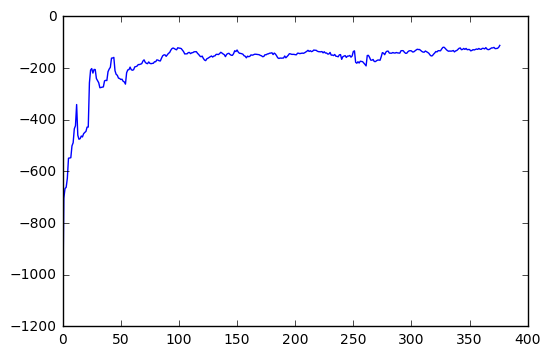

In [30]:
plt.plot(running_mean(rewards))

Since mountaincar has only 2 state variables (position and velocity) we can also plot the Q-function learnt by the neural network. Below we generate a grid of points over the state space and calculate the maximum Q-value at each state.

In [32]:
#create grid
highs = env.observation_space.high
lows = env.observation_space.low
Xs, Ys = np.meshgrid(np.linspace(lows[0],highs[0],30), np.linspace(lows[1],highs[1],30))
Zs = np.zeros_like(Xs)

for idx in range(Xs.size):
    s = np.zeros((1,2))
    s[0,0]=Xs.flat[idx]
    s[0,1]=Ys.flat[idx]
    Zs.flat[idx] = np.max(agent.get_values(s)) #max qvalue at state


3d surface plot using matplotlib:

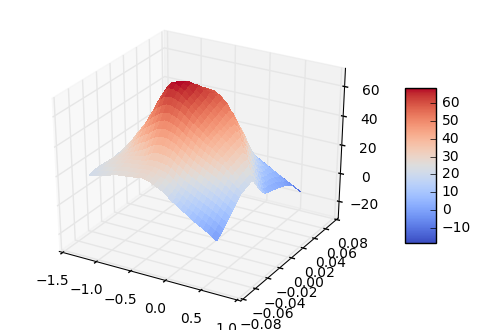

In [33]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(Xs, Ys, -Zs, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Compare with the value function obtained by Barto & Sutton:
https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node89.html   

We can also run the policy learnt by the agent:

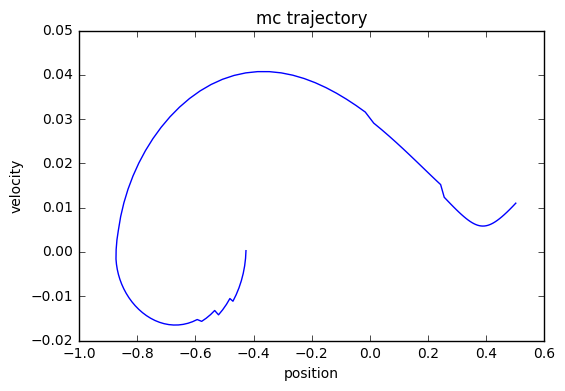

In [35]:
obs = env.reset()
log = []
for step in range(1000):
    #this is still e-greedy
    action = agent.select_action(obs[np.newaxis,:])
    obs,rew,terminal,_ = env.step(action)
    log.append(obs)
    # uncomment to visualize, might not work in notebook on all systems:
    # env.render()
    if terminal:
        break
        
    
log = np.array(log)

#plot the trajectory
plt.title('mc trajectory')
plt.xlabel('position')
plt.ylabel('velocity')

plt.plot(log[:,0],log[:,1])

# Assignment

Adapt the code above to try DQN with different networks. Things you can try:

- More / less hidden layers
- Larger / smaller hidden layer
- More / Less regularization (either weight_decay or dropout)
- Other activation functions

Try at least 3 networks and evaluate their performance.

Optional other things you can try to adapt DQN:
- change learning rate
- change replay size
- change target network update frequency
- Try getting DQN to work on the Acrobot-v1 or CartPole-v1 environments

Plot the results for your experiments, save the notebook as pdf and mail to Peter.